# Enhanced Soil Fertility Analysis using K-Nearest Neighbors (KNN)

This notebook implements an enhanced KNN model for soil fertility analysis using:
1. Feature Engineering and Selection
2. Class Imbalance Handling
3. Ensemble Learning
4. Advanced Model Evaluation
5. Feature Importance Analysis

In [71]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, auc, precision_recall_curve
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import cycle
import joblib

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

np.random.seed(42)

## 1. Data Loading and Exploration

In [72]:
# Load dataset
df = pd.read_csv('../Datasets/dataset_1.csv')
print('Dataset Info:')
print(df.info())
print('\nFirst few rows:')
print(df.head())
print('\nSummary statistics:')
print(df.describe())
print('\nClass distribution:')
print(df['Output'].value_counts(normalize=True))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       880 non-null    int64  
 1   P       880 non-null    float64
 2   K       880 non-null    int64  
 3   EC      880 non-null    float64
 4   Fe      880 non-null    float64
 5   Output  880 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 41.4 KB
None

First few rows:
     N    P    K    EC    Fe  Output
0  138  8.6  560  0.62  0.31       0
1  213  7.5  338  0.75  0.86       0
2  163  9.6  718  0.51  0.86       0
3  157  6.8  475  0.58  0.54       0
4  270  9.9  444  0.40  0.76       1

Summary statistics:
               N           P           K          EC          Fe      Output
count  880.00000  880.000000  880.000000  880.000000  880.000000  880.000000
mean   246.73750   14.562159  499.978409    0.543659    4.140523    0.588636
std     77.38886   21.967755  124.22283

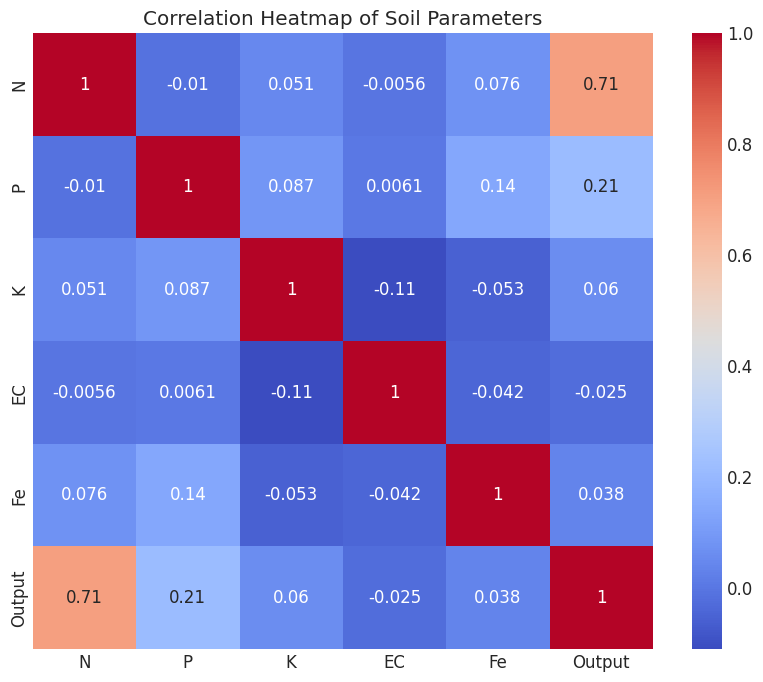

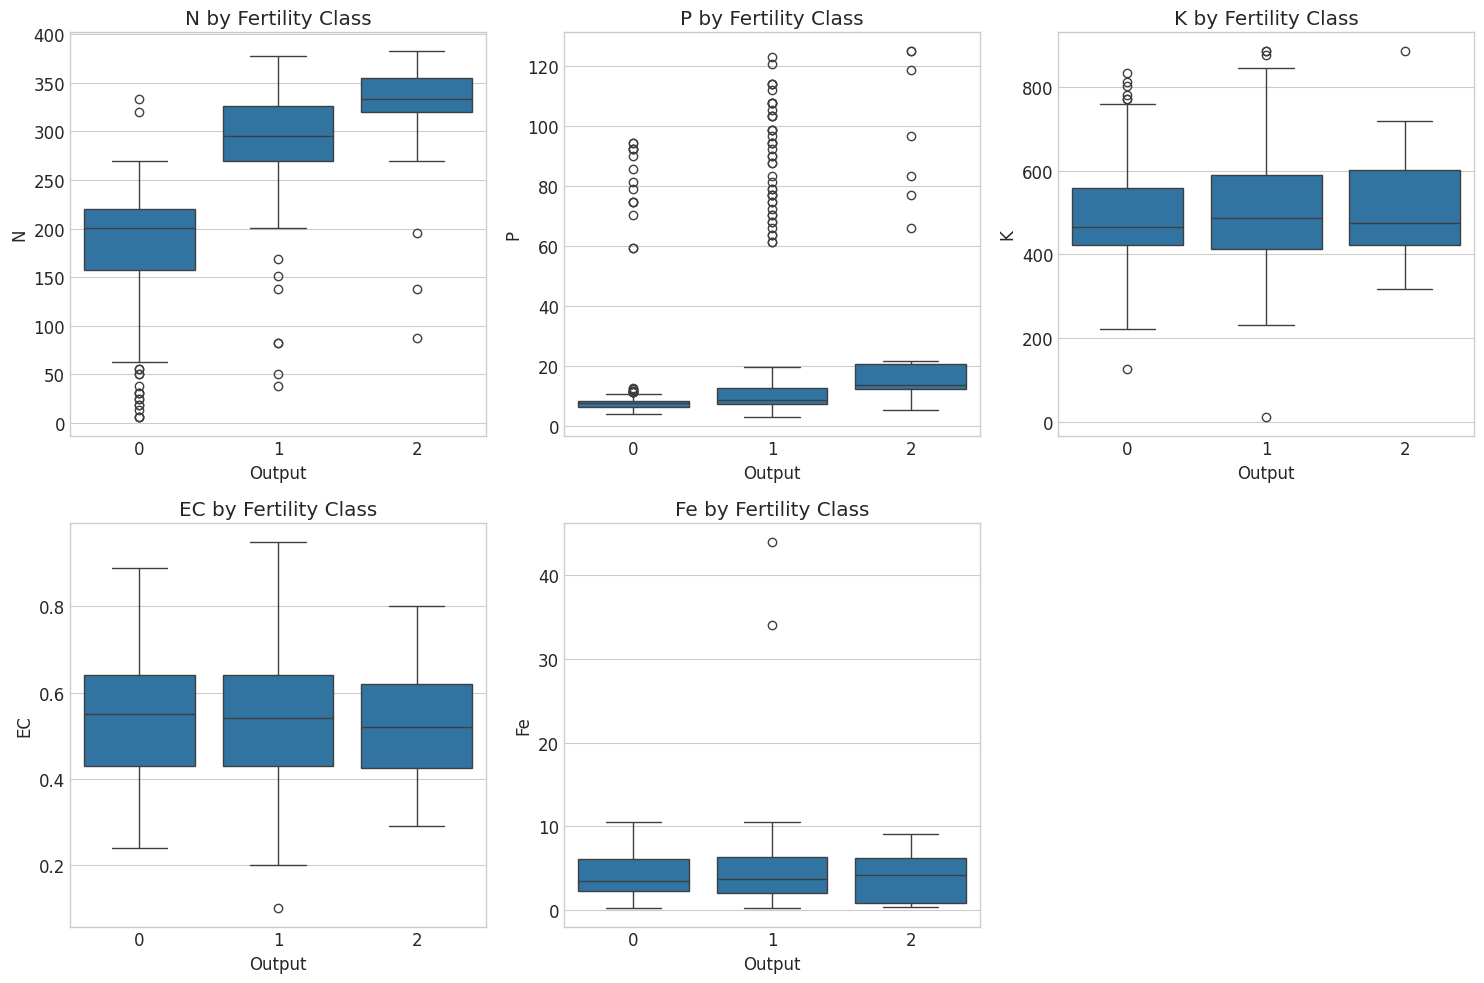

In [73]:
# Data visualization
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Soil Parameters')
plt.show()

features = ['N', 'P', 'K', 'EC', 'Fe']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Output', y=feature, data=df)
    plt.title(f'{feature} by Fertility Class')
plt.tight_layout()
plt.show()

## 2. Enhanced Model Pipeline Setup

In [74]:
# Prepare data
X = df.drop('Output', axis=1)
y = df['Output']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create ensemble of KNN classifiers
estimators = [
    ('knn1', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski', p=2)),
    ('knn2', KNeighborsClassifier(n_neighbors=7, weights='distance', metric='manhattan')),
    ('knn3', KNeighborsClassifier(n_neighbors=9, weights='uniform', metric='chebyshev'))
]

ensemble = VotingClassifier(estimators=estimators, voting='soft')

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('selector', SelectKBest(score_func=f_classif, k=20)),
    ('smote', SMOTE(random_state=42)),
    ('ensemble', ensemble)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('selector', SelectKBest(k=20)),
                ('smote', SMOTE(random_state=42)),
                ('ensemble',
                 VotingClassifier(estimators=[('knn1',
                                               KNeighborsClassifier(weights='distance')),
                                              ('knn2',
                                               KNeighborsClassifier(metric='manhattan',
                                                                    n_neighbors=7,
                                                                    weights='distance')),
                                              ('knn3',
                                               KNeighborsClassifier(metric='chebyshev',
                                                                    n_neighbors=9))],
                                  voting='soft'))])

## 3. Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        80
           1       0.78      0.70      0.74        88
           2       0.11      0.25      0.15         8

    accuracy                           0.75       176
   macro avg       0.59      0.60      0.58       176
weighted avg       0.79      0.75      0.77       176



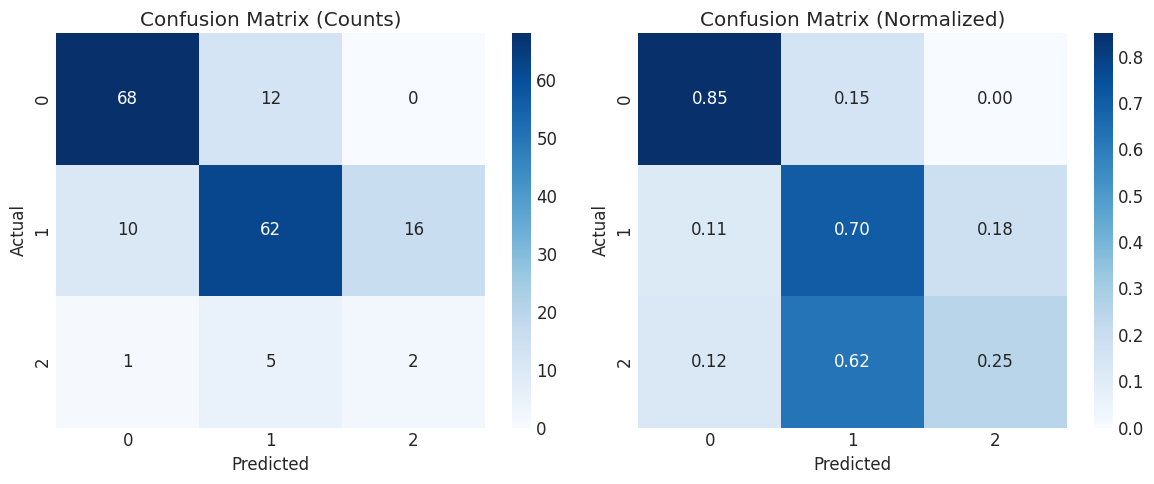

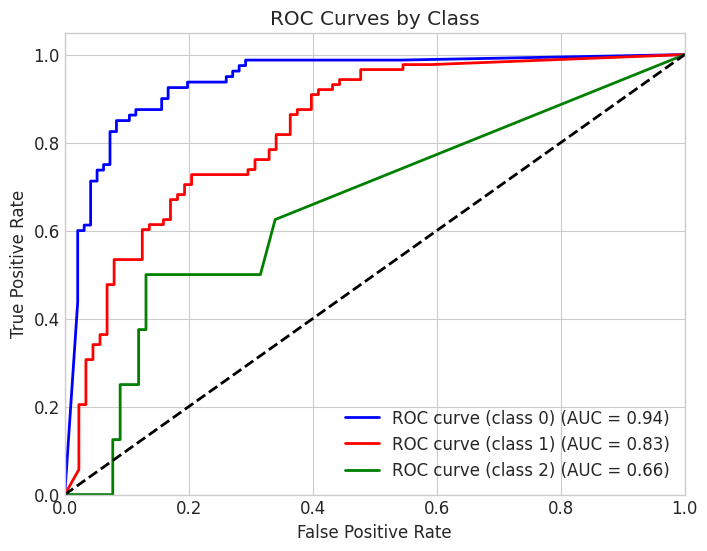

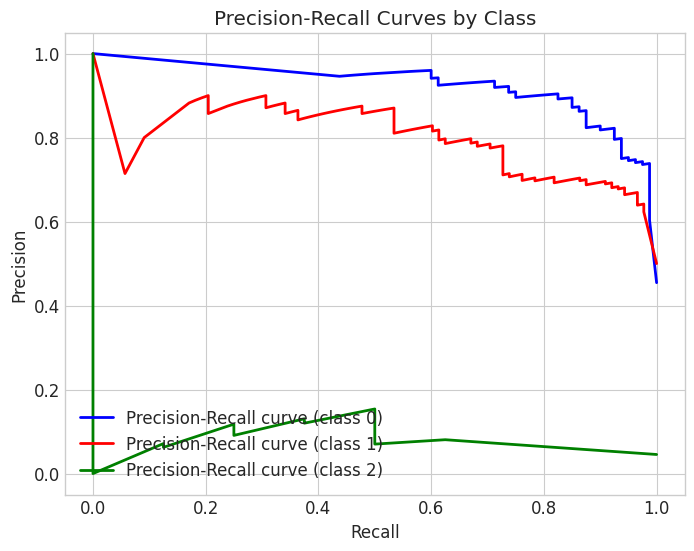

In [75]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

print('Classification Report:')
print(classification_report(y_test, y_pred))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC curves
n_classes = len(np.unique(y))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curves
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_proba[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=f'Precision-Recall curve (class {i})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves by Class')
plt.legend(loc='lower left')
plt.show()

## 4. Feature Importance Analysis

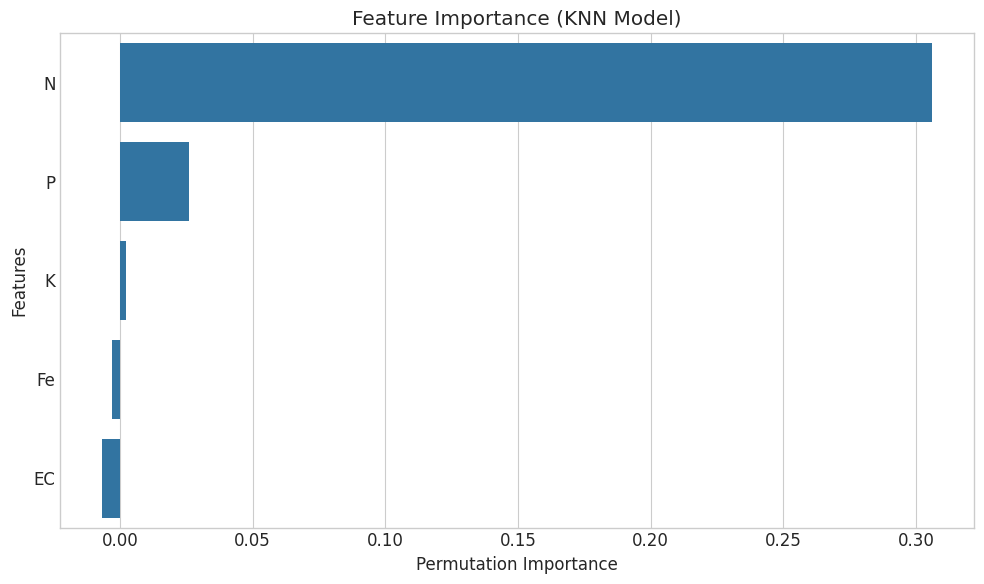


Feature Importance Ranking:
  feature  importance
0       N    0.306250
1       P    0.026136
2       K    0.002273
4      Fe   -0.002841
3      EC   -0.006818


In [76]:
# Permutation importance
result = permutation_importance(
    pipeline, X_test, y_test,
    n_repeats=10,
    random_state=42
)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance (KNN Model)')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
print('\nFeature Importance Ranking:')
print(importance_df)

## 5. Model Export and Example Prediction

In [77]:
# Save the complete pipeline
joblib.dump(pipeline, '../Models/enhanced_soil_fertility_knn.joblib')
importance_df.to_csv('../Models/enhanced_knn_feature_importance.csv', index=False)
print('Model and feature importance saved successfully!')

# Example prediction
sample_input = pd.DataFrame({
    'N': [200],
    'P': [8.0],
    'K': [500],
    'EC': [0.5],
    'Fe': [0.6]
})
prediction = pipeline.predict(sample_input)
probabilities = pipeline.predict_proba(sample_input)
print('\nExample Prediction:')
print('Input Features:')
print(sample_input)
print(f'\nPredicted class: {prediction[0]}')
print('\nClass probabilities:')
for i, prob in enumerate(probabilities[0]):
    print(f'Class {i}: {prob:.4f}')

Model and feature importance saved successfully!

Example Prediction:
Input Features:
     N    P    K   EC   Fe
0  200  8.0  500  0.5  0.6

Predicted class: 0

Class probabilities:
Class 0: 0.8889
Class 1: 0.1111
Class 2: 0.0000


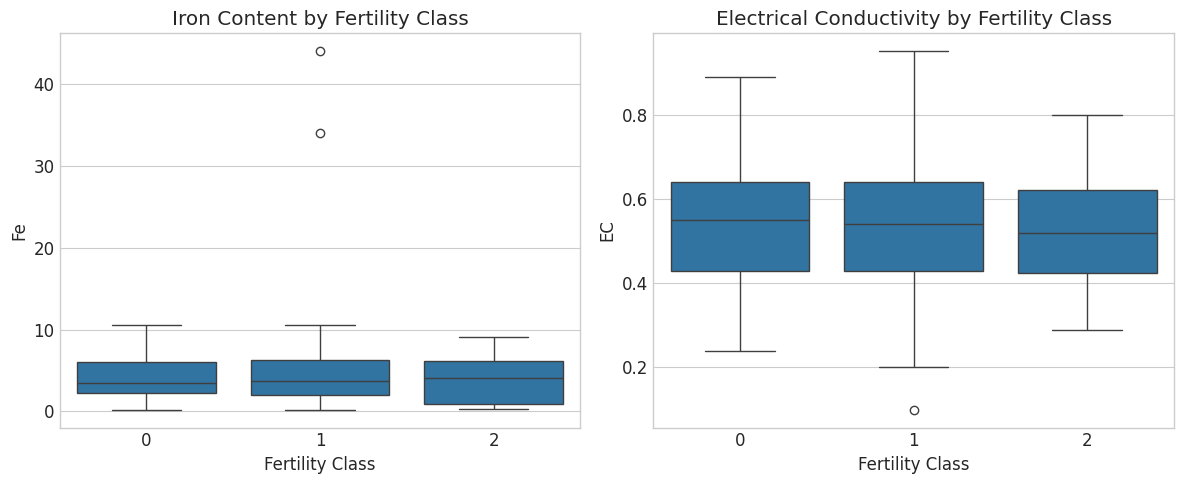

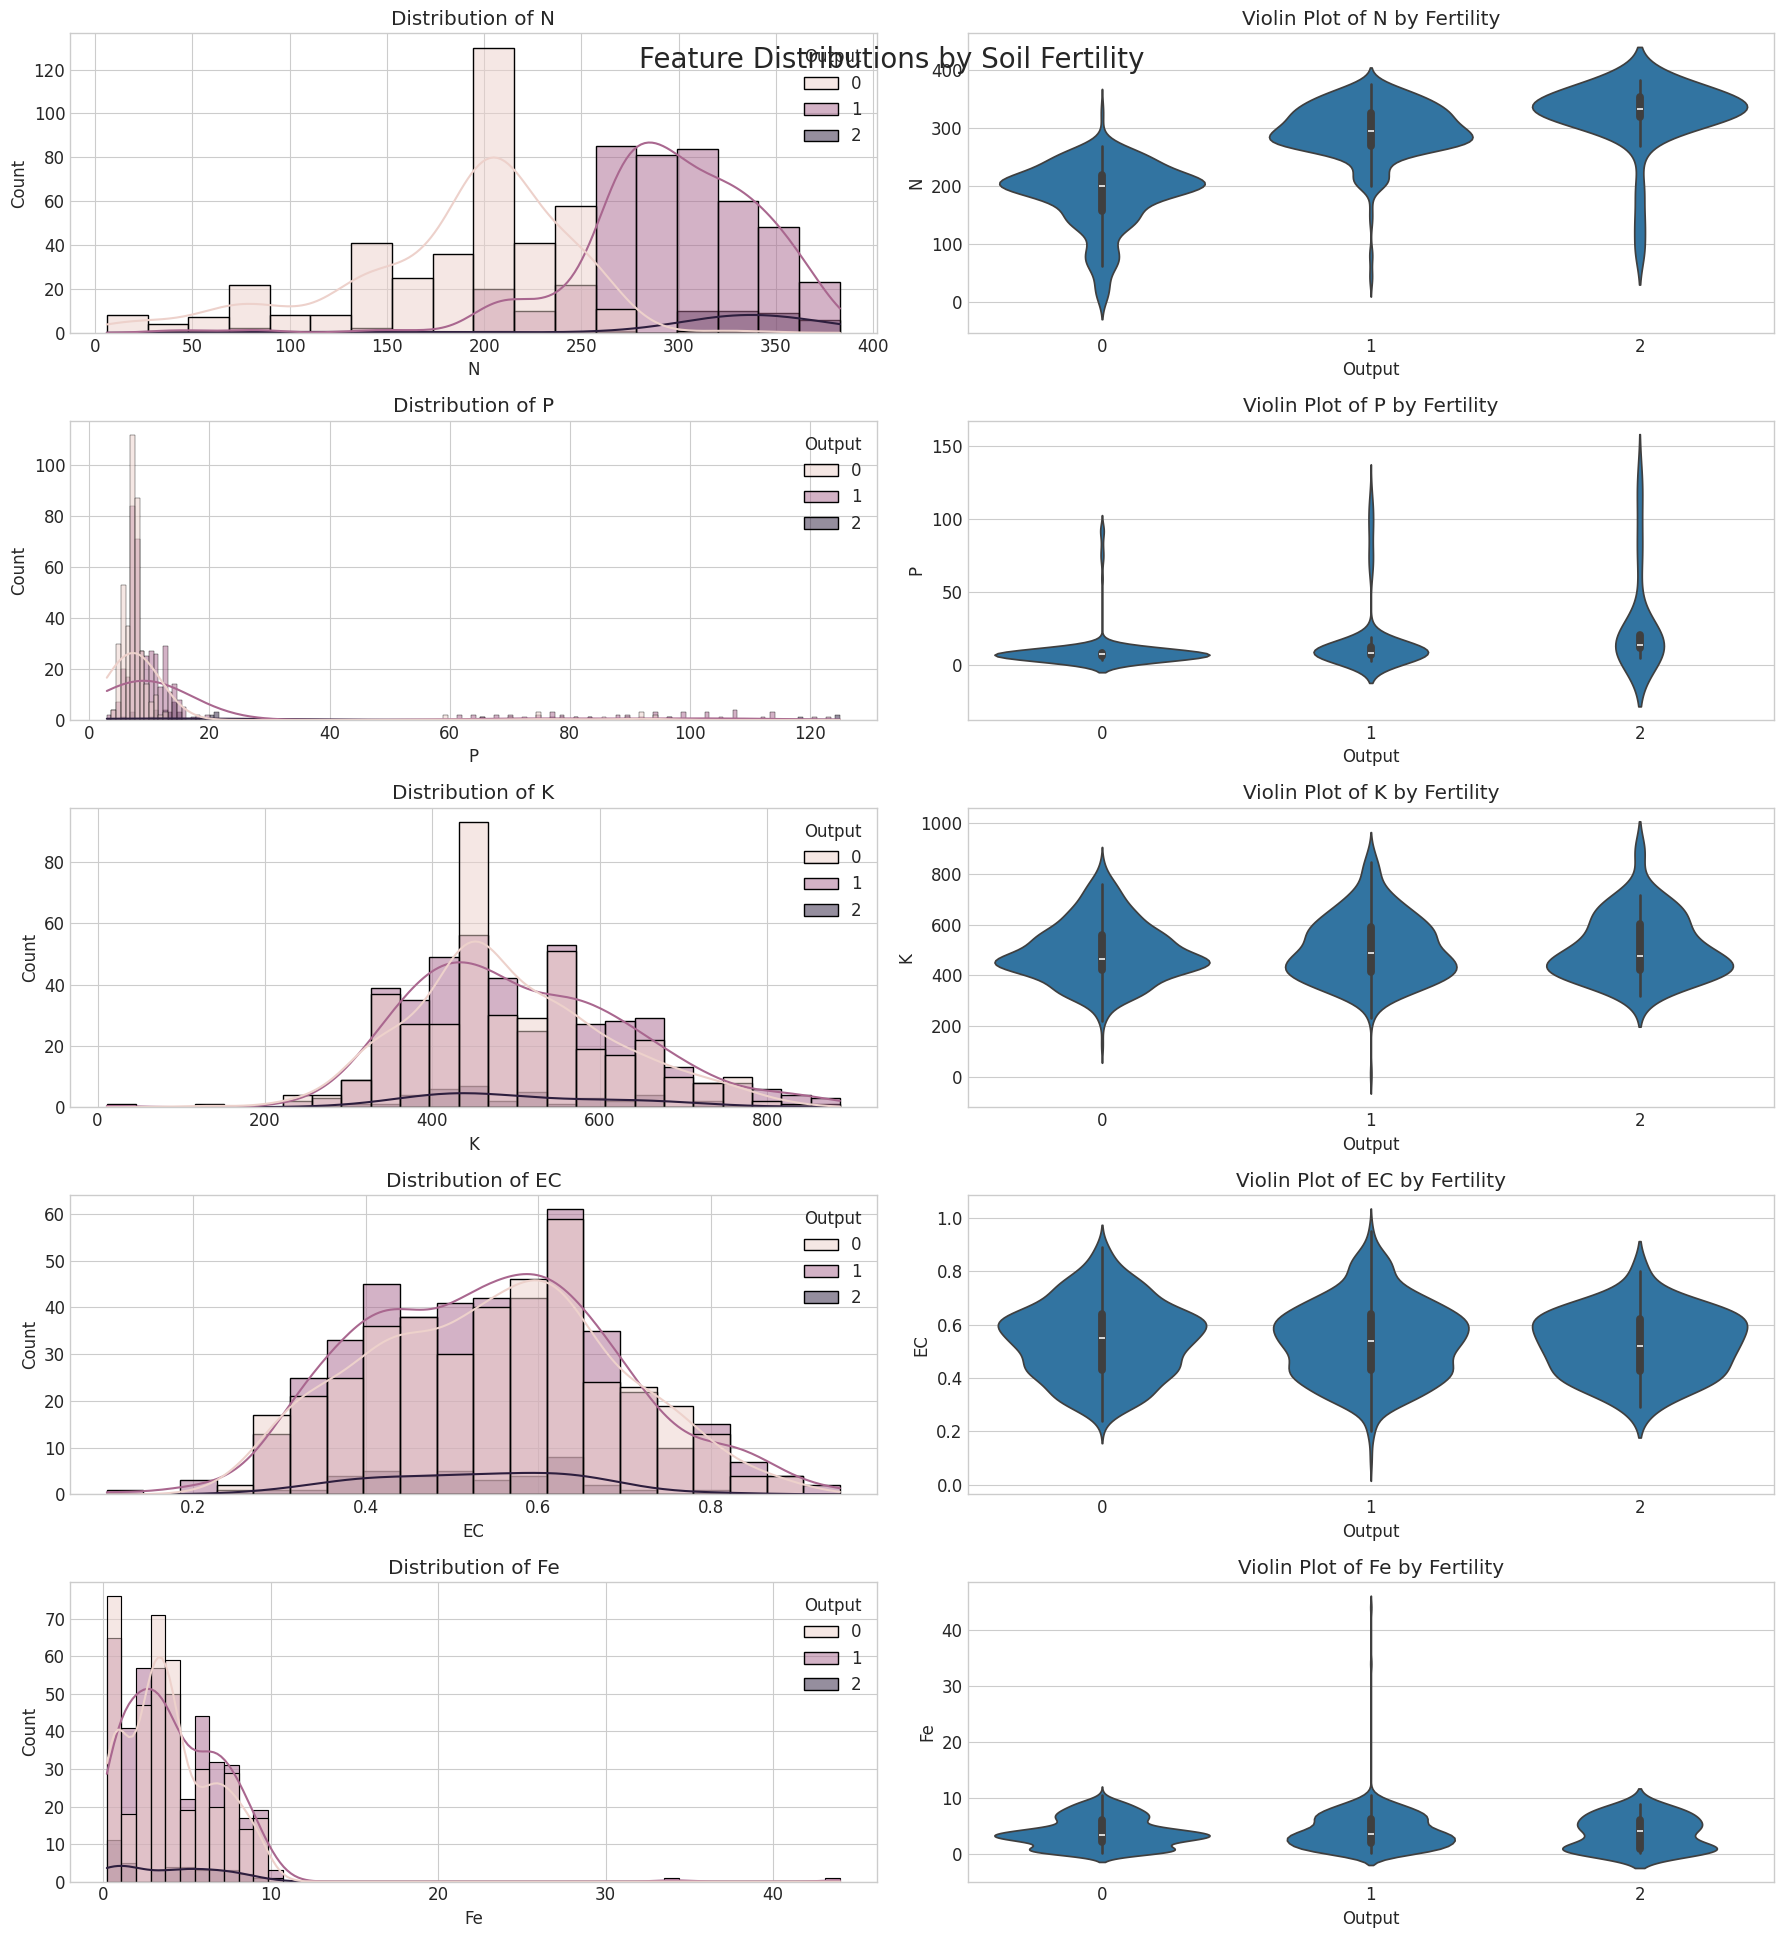

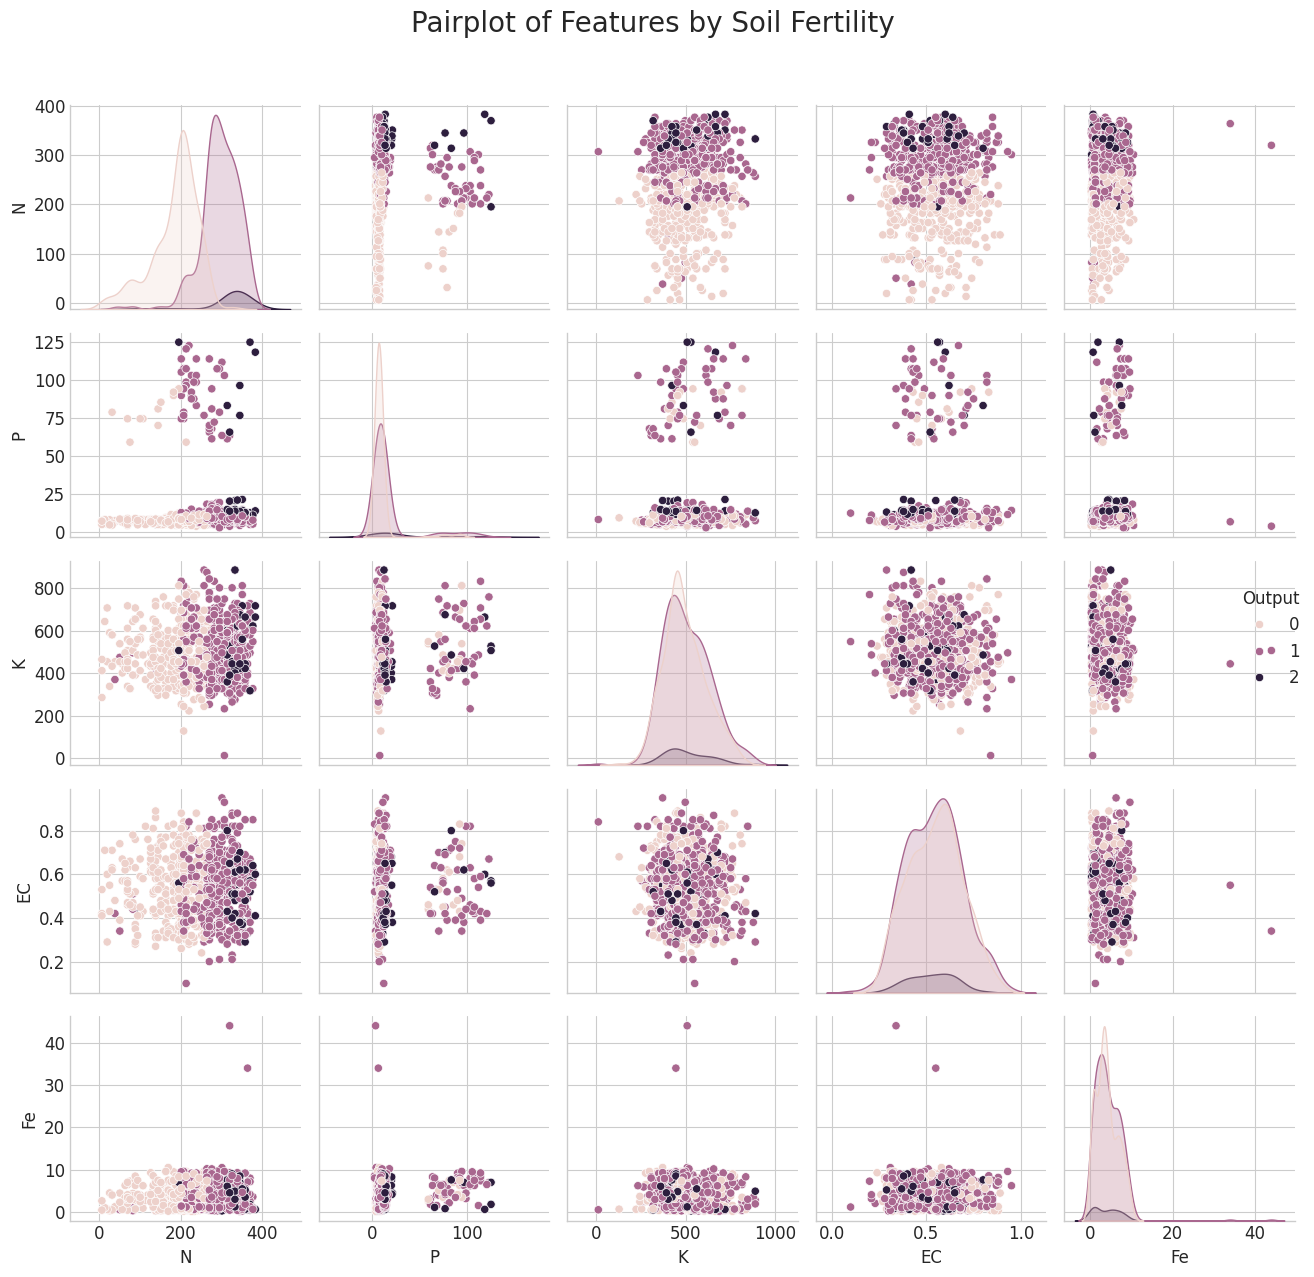

In [78]:
# Enhanced feature distribution visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='Output', y='Fe', data=df)
plt.title('Iron Content by Fertility Class')
plt.xlabel('Fertility Class')
plt.ylabel('Fe')
plt.subplot(1, 2, 2)
sns.boxplot(x='Output', y='EC', data=df)
plt.title('Electrical Conductivity by Fertility Class')
plt.xlabel('Fertility Class')
plt.ylabel('EC')
plt.tight_layout()
plt.show()

# Distribution plots
features = ['N', 'P', 'K', 'EC', 'Fe']
fig, axes = plt.subplots(len(features), 2, figsize=(18, 20))
fig.suptitle('Feature Distributions by Soil Fertility', fontsize=20, y=0.95)

for i, feature in enumerate(features):
    # Histogram with KDE
    sns.histplot(data=df, x=feature, hue='Output', kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {feature}')
    
    # Violin plot
    sns.violinplot(data=df, x='Output', y=feature, ax=axes[i, 1])
    axes[i, 1].set_title(f'Violin Plot of {feature} by Fertility')
    
plt.tight_layout()
plt.show()

# Pairplot with KDE
sns.pairplot(df, hue='Output', diag_kind='kde')
plt.suptitle('Pairplot of Features by Soil Fertility', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

Performing grid search with 5-fold cross-validation...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best parameters: {'ensemble__estimators': [('knn1', KNeighborsClassifier(n_neighbors=3, weights='distance')), ('knn2', KNeighborsClassifier(metric='manhattan', weights='distance')), ('knn3', KNeighborsClassifier(metric='chebyshev', n_neighbors=7))], 'ensemble__voting': 'soft'}
Best cross-validation score: 0.8168

Best parameters: {'ensemble__estimators': [('knn1', KNeighborsClassifier(n_neighbors=3, weights='distance')), ('knn2', KNeighborsClassifier(metric='manhattan', weights='distance')), ('knn3', KNeighborsClassifier(metric='chebyshev', n_neighbors=7))], 'ensemble__voting': 'soft'}
Best cross-validation score: 0.8168


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)


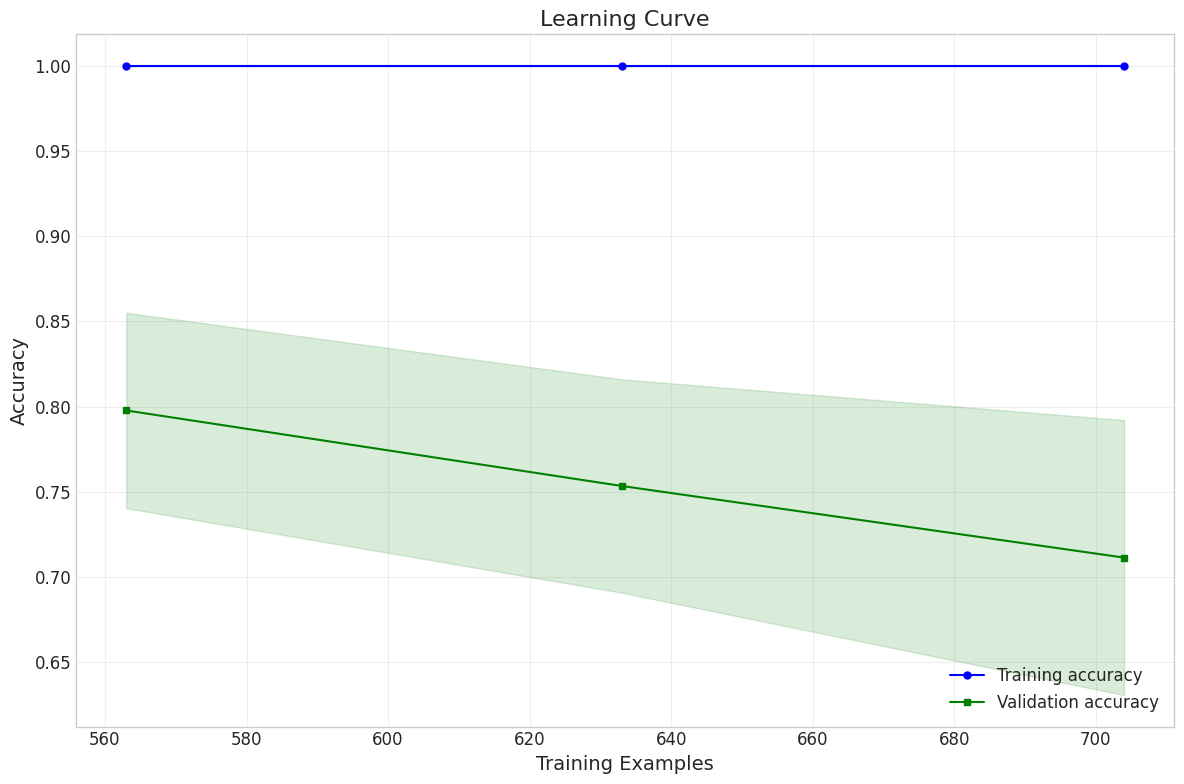

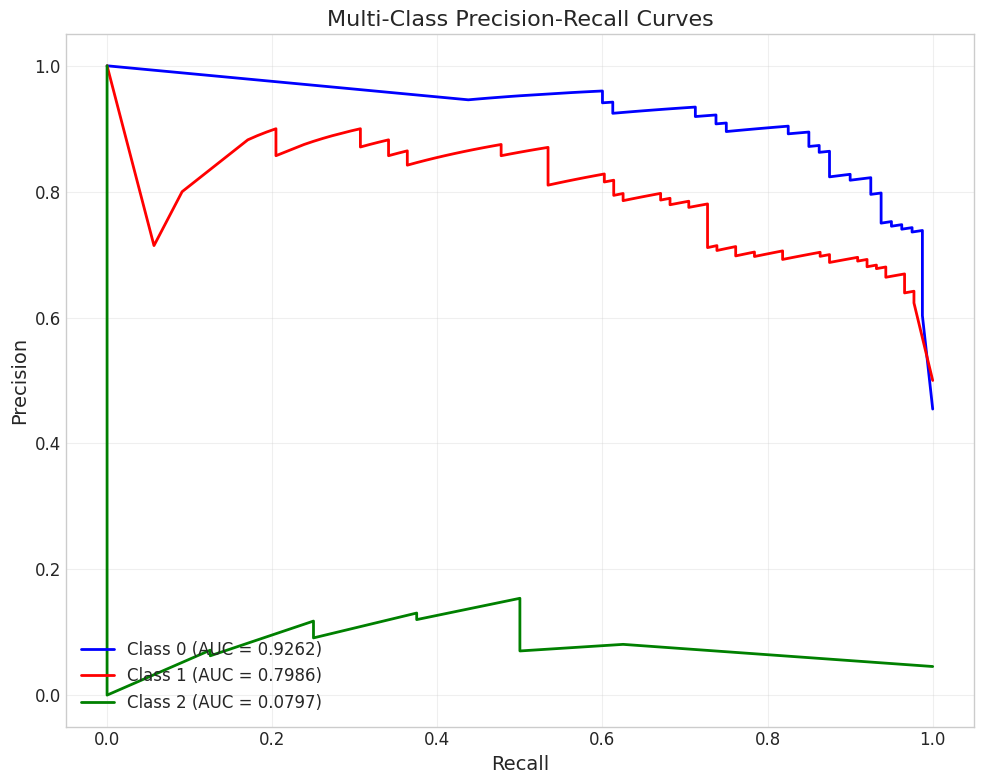

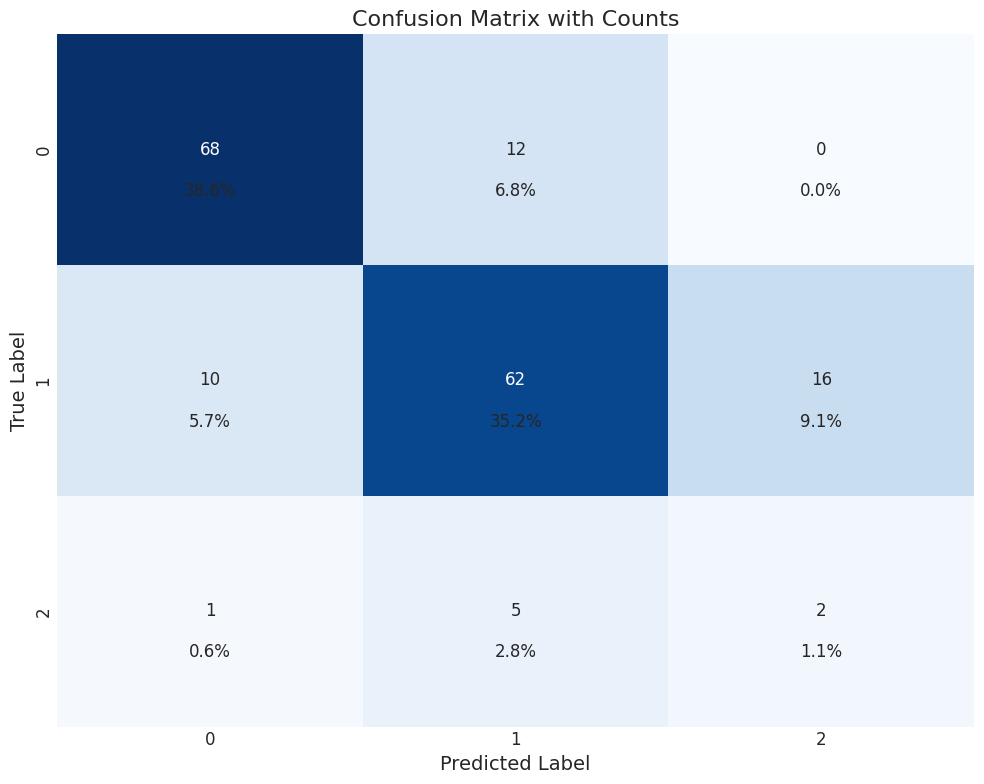


Detailed Classification Metrics:

Classification Report:
                precision    recall  f1-score   support

   Not Fertile       0.86      0.85      0.86        80
       Fertile       0.78      0.70      0.74        88
Highly Fertile       0.11      0.25      0.15         8

      accuracy                           0.75       176
     macro avg       0.59      0.60      0.58       176
  weighted avg       0.79      0.75      0.77       176


Class-wise Accuracies:
Class 0: 0.8500
Class 1: 0.7045
Class 2: 0.2500

Cross-validation Scores:
Mean CV Score: 0.7114 (+/- 0.1614)


In [79]:
# Create pipeline with grid search
param_grid = {
    'ensemble__voting': ['soft'],
    'ensemble__estimators': [
        [
            ('knn1', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski', p=2)),
            ('knn2', KNeighborsClassifier(n_neighbors=7, weights='distance', metric='manhattan')),
            ('knn3', KNeighborsClassifier(n_neighbors=9, weights='uniform', metric='chebyshev'))
        ],
        [
            ('knn1', KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski', p=2)),
            ('knn2', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan')),
            ('knn3', KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='chebyshev'))
        ]
    ]
}

print("Performing grid search with 5-fold cross-validation...")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Update pipeline with best model
pipeline = grid_search.best_estimator_

# Plot learning curves
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.title('Learning Curve', fontsize=16)
plt.xlabel('Training Examples', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

# Enhanced model evaluation
# Precision-Recall curves
classes = sorted(df['Output'].unique())
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
pr_auc = dict()

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green'])

for i, color in zip(range(n_classes), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    plt.plot(recall[i], precision[i], color=color, lw=2, 
             label=f'Class {i} (AUC = {pr_auc[i]:.4f})')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Multi-Class Precision-Recall Curves', fontsize=16)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Enhanced confusion matrix with percentages
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix with Counts', fontsize=16)

# Add percentage annotations
total = np.sum(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.7, 
                f"{cm[i, j] / total * 100:.1f}%",
                ha="center", fontsize=12)

plt.tight_layout()
plt.show()

# Print detailed classification metrics
print("\nDetailed Classification Metrics:")
print("================================")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Fertile', 'Fertile', 'Highly Fertile']))

# Calculate and print class-wise accuracies
class_accuracies = {}
for i in range(n_classes):
    mask = y_test == i
    class_accuracies[i] = accuracy_score(y_test[mask], y_pred[mask])
    
print("\nClass-wise Accuracies:")
print("=====================")
for i in range(n_classes):
    print(f"Class {i}: {class_accuracies[i]:.4f}")

# Calculate and print cross-validation scores
cv_scores = cross_val_score(pipeline, X, y, cv=5)
print("\nCross-validation Scores:")
print("======================")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

## 6. Enhanced Prediction Function

Enhanced Model Predictions with Confidence Analysis:



--------------------------------------------------
Test Case 1 Analysis:
--------------------------------------------------
Input Parameters:
  N: 150.00
  P: 8.00
  K: 500.00
  EC: 0.50
  Fe: 1.00

Prediction Results:
  Predicted Class: Not Fertile
  Confidence Score: 0.8518

Class Probability Distribution:
  Not Fertile.........  85.18% |==========================================
  Fertile.............  14.82% |=======
  Highly Fertile......   0.00% |

Feature Importance Analysis:
  N.........   0.00% |
  P.........   0.00% |
  K.........   0.00% |
  EC........   0.00% |
  Fe........   0.00% |

--------------------------------------------------
Test Case 2 Analysis:
--------------------------------------------------
Input Parameters:
  N: 280.00
  P: 10.00
  K: 450.00
  EC: 0.40
  Fe: 3.00

Prediction Results:
  Predicted Class: Fertile
  Confidence Score: 0.8876

Class Probability Distribution:
  Not Fertile.........  11.24% |=====
  Fertile.............  88.76% |==================

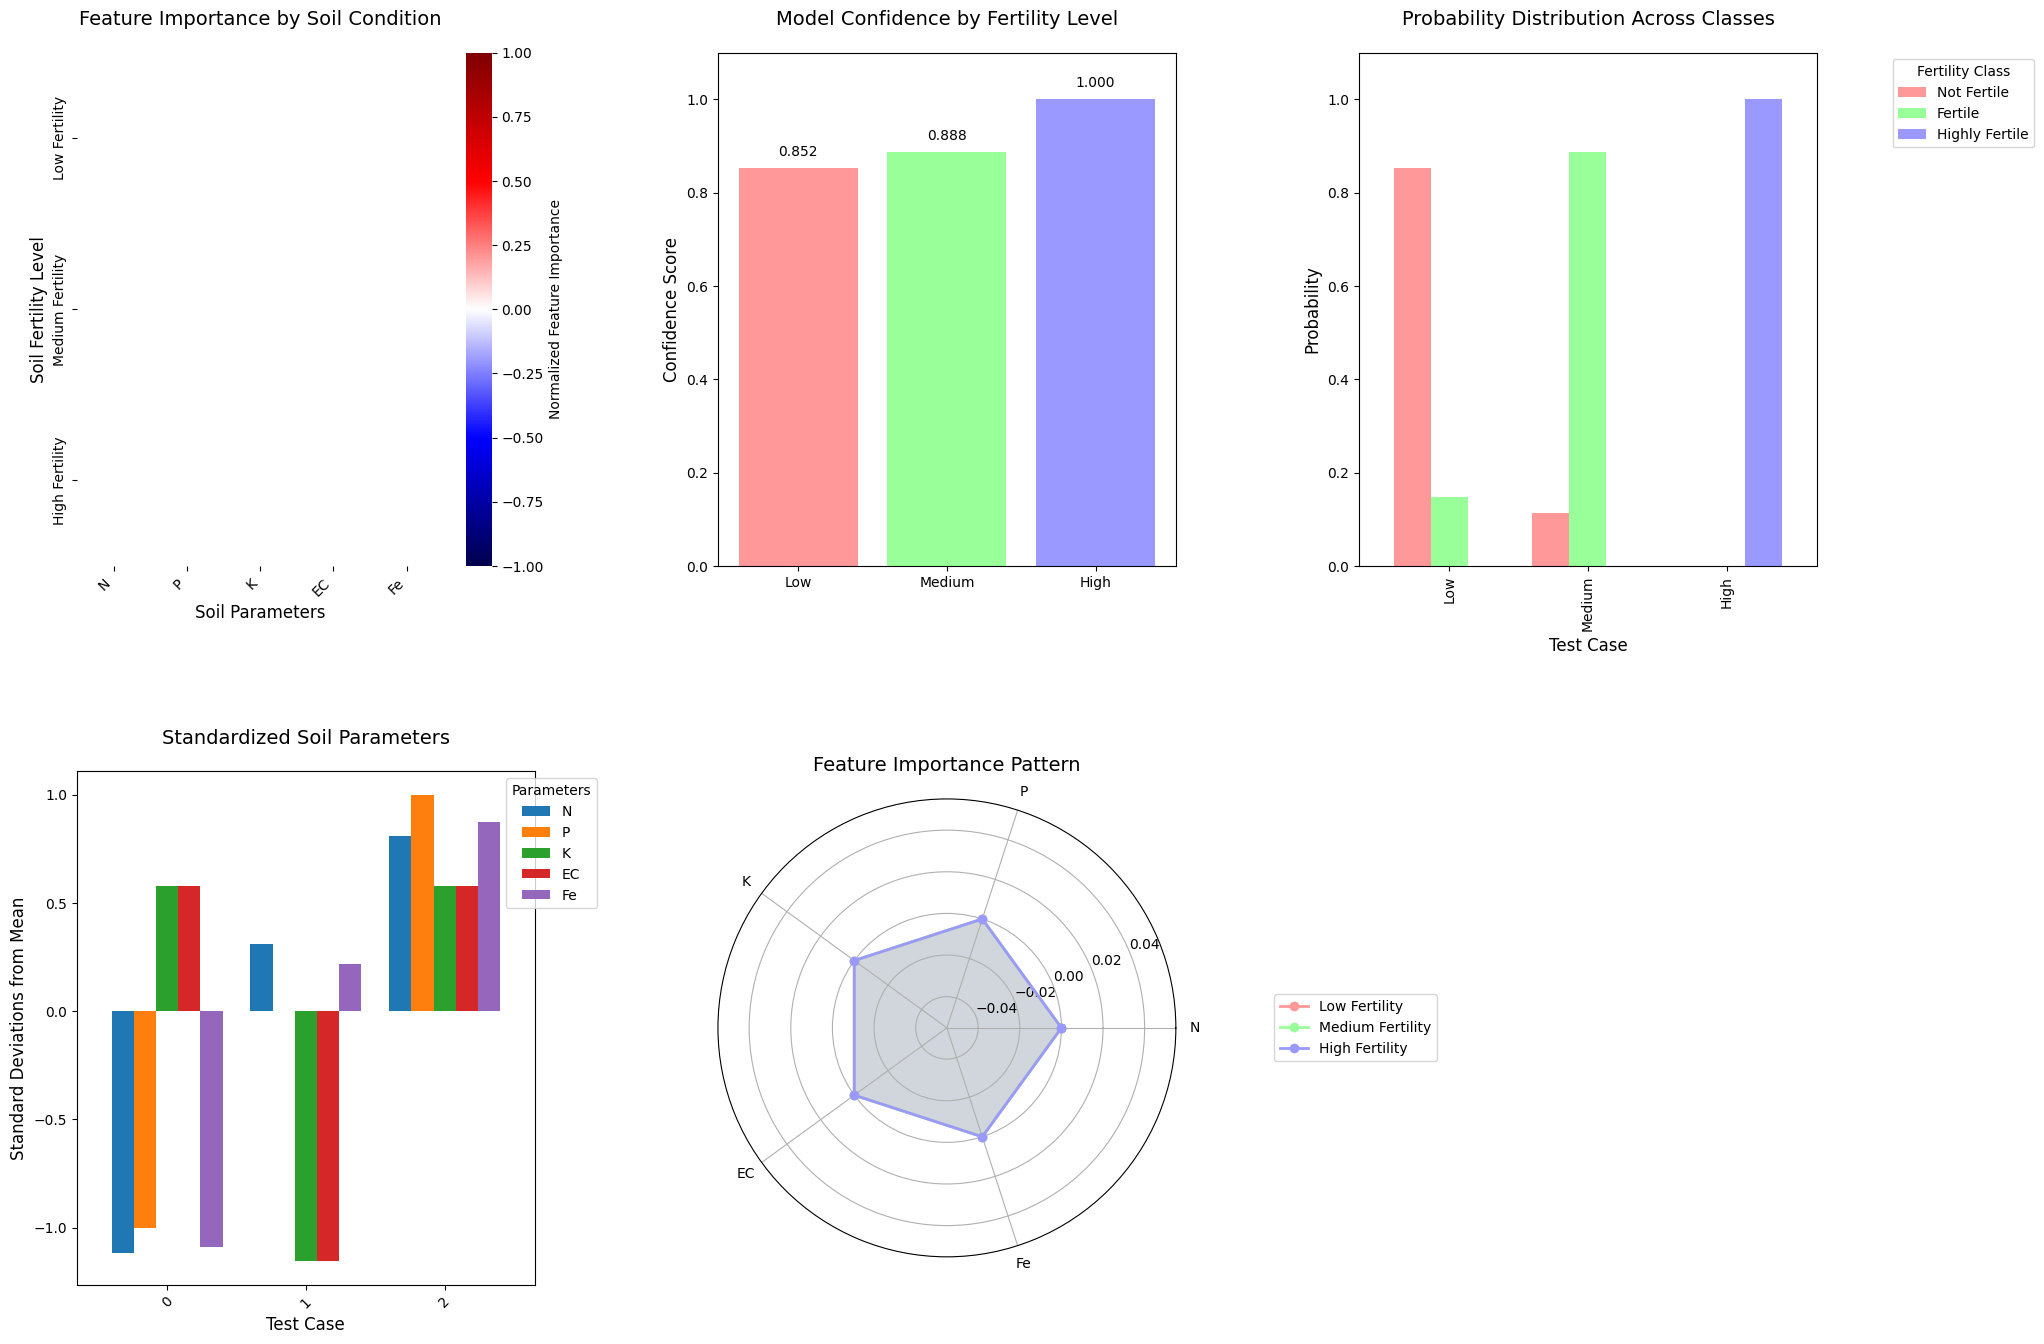


Model Performance Summary:
Average Prediction Confidence: 0.9131
Confidence Consistency (Std Dev): 0.0631

Key Features by Fertility Level:
Low Fertility: N (Importance: 0.0000)
Medium Fertility: N (Importance: 0.0000)
High Fertility: N (Importance: 0.0000)


In [80]:
# Enhanced prediction function with confidence scores and detailed reporting
def predict_soil_fertility_with_confidence(n, p, k, ec, fe):
    """
    Predict soil fertility with confidence scores and detailed analysis.
    
    Parameters:
    - n: Nitrogen level (ppm)
    - p: Phosphorus level (ppm)
    - k: Potassium level (ppm)
    - ec: Electrical Conductivity (dS/m)
    - fe: Iron level (ppm)
    
    Returns:
    - Dict containing prediction details
    """
    input_data = pd.DataFrame({
        'N': [n], 'P': [p], 'K': [k], 'EC': [ec], 'Fe': [fe]
    })
    
    # Get prediction and probabilities
    prediction = pipeline.predict(input_data)[0]
    probabilities = pipeline.predict_proba(input_data)[0]
    confidence = np.max(probabilities)
    
    # Get feature importance for this prediction
    feature_importance = permutation_importance(
        pipeline, input_data, np.array([prediction]), 
        n_repeats=5, random_state=42
    )
    
    # Create results dictionary
    fertility_classes = {
        0: "Not Fertile", 
        1: "Fertile", 
        2: "Highly Fertile"
    }
    
    results = {
        'prediction': fertility_classes[prediction],
        'prediction_class': prediction,
        'confidence': confidence,
        'class_probabilities': {
            fertility_classes[i]: prob 
            for i, prob in enumerate(probabilities)
        },
        'feature_importance': {
            feature: importance 
            for feature, importance in zip(['N', 'P', 'K', 'EC', 'Fe'], feature_importance.importances_mean)
        }
    }
    
    return results

# Test cases with different soil conditions
test_cases = [
    # Low fertility case
    {'N': 150, 'P': 8.0, 'K': 500, 'EC': 0.5, 'Fe': 1.0},
    # Medium fertility case
    {'N': 280, 'P': 10.0, 'K': 450, 'EC': 0.4, 'Fe': 3.0},
    # High fertility case
    {'N': 325, 'P': 12.0, 'K': 500, 'EC': 0.5, 'Fe': 4.0}
]

print("Enhanced Model Predictions with Confidence Analysis:")
print("================================================")

all_results = []  # Store results for comparison
feature_importance_across_cases = []

for i, case in enumerate(test_cases, 1):
    results = predict_soil_fertility_with_confidence(
        case['N'], case['P'], case['K'], case['EC'], case['Fe']
    )
    all_results.append(results)
    feature_importance_across_cases.append(results['feature_importance'])
    
    print(f"\n{'-'*50}")
    print(f"Test Case {i} Analysis:")
    print(f"{'-'*50}")
    print(f"Input Parameters:")
    for param, value in case.items():
        print(f"  {param}: {value:.2f}")
    
    print(f"\nPrediction Results:")
    print(f"  Predicted Class: {results['prediction']}")
    print(f"  Confidence Score: {results['confidence']:.4f}")
    
    print("\nClass Probability Distribution:")
    for class_name, prob in results['class_probabilities'].items():
        prob_percentage = prob * 100
        bars = "=" * int(prob_percentage / 2)
        print(f"  {class_name:.<20} {prob_percentage:>6.2f}% |{bars}")
    
    print("\nFeature Importance Analysis:")
    importance_sorted = sorted(
        results['feature_importance'].items(), 
        key=lambda x: abs(x[1]), 
        reverse=True
    )
    for feature, importance in importance_sorted:
        importance_percentage = abs(importance) * 100
        bars = "*" * int(importance_percentage / 2)
        print(f"  {feature:.<10} {importance_percentage:>6.2f}% |{bars}")

# Save the enhanced model
joblib.dump(pipeline, '../Models/enhanced_soil_fertility_knn.joblib')
print("\nEnhanced model saved successfully!")

# Visualization of results with improved readability
plt.style.use('default')
fig = plt.figure(figsize=(24, 16))

# Set consistent color scheme
colors = ['#FF9999', '#99FF99', '#9999FF']  # Red, Green, Blue pastels

# Create a figure with proper spacing
gs = plt.GridSpec(2, 3, figure=fig, height_ratios=[1, 1], hspace=0.4, wspace=0.4)

# 1. Feature Importance Heatmap
ax1 = fig.add_subplot(gs[0, 0])
importance_data = pd.DataFrame(feature_importance_across_cases)
importance_data.index = ['Low Fertility', 'Medium Fertility', 'High Fertility']

# Scale the data between -1 and 1 for better visualization
max_abs_val = np.abs(importance_data.values).max()
scaled_data = importance_data / max_abs_val

# Create heatmap with diverging colormap
sns.heatmap(scaled_data, 
            annot=importance_data.values,  # Show original values in annotations
            cmap='seismic',  # Use seismic colormap for better contrast
            vmin=-1, vmax=1, center=0,
            fmt='.3f', ax=ax1,
            cbar_kws={'label': 'Normalized Feature Importance'})

ax1.set_title('Feature Importance by Soil Condition', fontsize=14, pad=20)
ax1.set_ylabel('Soil Fertility Level', fontsize=12)
ax1.set_xlabel('Soil Parameters', fontsize=12)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# 2. Confidence Score Comparison
ax2 = fig.add_subplot(gs[0, 1])
confidence_scores = [result['confidence'] for result in all_results]
fertility_levels = ['Low', 'Medium', 'High']
bars = ax2.bar(fertility_levels, confidence_scores, color=colors)
ax2.set_title('Model Confidence by Fertility Level', fontsize=14, pad=20)
ax2.set_ylabel('Confidence Score', fontsize=12)
ax2.set_ylim(0, 1.1)  # Increased ylim for better label visibility
for bar, score in zip(bars, confidence_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, score + 0.02,
             f'{score:.3f}', ha='center', va='bottom')

# 3. Class Probability Distribution
ax3 = fig.add_subplot(gs[0, 2])
class_probs = pd.DataFrame([result['class_probabilities'] for result in all_results],
                          index=['Low', 'Medium', 'High'])
class_probs.plot(kind='bar', width=0.8, color=colors, ax=ax3)
ax3.set_title('Probability Distribution Across Classes', fontsize=14, pad=20)
ax3.set_xlabel('Test Case', fontsize=12)
ax3.set_ylabel('Probability', fontsize=12)
ax3.legend(title='Fertility Class', bbox_to_anchor=(1.15, 1))
ax3.set_ylim(0, 1.1)

# 4. Normalized Feature Values
ax4 = fig.add_subplot(gs[1, 0])
feature_values = pd.DataFrame(test_cases)
feature_values_normalized = (feature_values - feature_values.mean()) / feature_values.std()
feature_values_normalized.plot(kind='bar', width=0.8, ax=ax4)
ax4.set_title('Standardized Soil Parameters', fontsize=14, pad=20)
ax4.set_xlabel('Test Case', fontsize=12)
ax4.set_ylabel('Standard Deviations from Mean', fontsize=12)
ax4.legend(title='Parameters', bbox_to_anchor=(1.15, 1))
ax4.tick_params(axis='x', rotation=45)

# 5. Radar Chart of Feature Importance
ax5 = fig.add_subplot(gs[1, 1], projection='polar')
features = list(importance_data.columns)
angles = np.linspace(0, 2*np.pi, len(features), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

for idx, (case, color) in enumerate(zip(['Low', 'Medium', 'High'], colors)):
    values = importance_data.iloc[idx].values
    values = np.concatenate((values, [values[0]]))
    ax5.plot(angles, values, 'o-', linewidth=2, label=f'{case} Fertility', color=color)
    ax5.fill(angles, values, alpha=0.25, color=color)
ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(features)
ax5.set_title('Feature Importance Pattern', fontsize=14, pad=20)
ax5.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))

# Add more spacing on the right for legends
plt.subplots_adjust(right=0.85)
plt.show()

# Summary Statistics
print("\nModel Performance Summary:")
print("========================")
print(f"Average Prediction Confidence: {np.mean(confidence_scores):.4f}")
print(f"Confidence Consistency (Std Dev): {np.std(confidence_scores):.4f}")
print("\nKey Features by Fertility Level:")
for i, case in enumerate(['Low Fertility', 'Medium Fertility', 'High Fertility']):
    top_feature = importance_data.iloc[i].abs().nlargest(1)
    print(f"{case}: {top_feature.index[0]} (Importance: {top_feature.values[0]:.4f})")